In [190]:
import cv2
import numpy as np
import pickle
import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Let us first read the train and test files

In [191]:
# train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
# test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
# train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
# test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
# train_labels = pickle.load(open('train_labels.dat','rb')) 
# test_labels = pickle.load(open('test_labels.dat','rb'))

In [192]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))

In [193]:
train_images_filenames[12]

'../MIT_split/train/Opencountry/fie26.jpg'

In [195]:
# import os

# for file in range(len(train_images_filenames)):
#     train_images_filenames[file] = train_images_filenames[file][3:]

# for file in range(len(test_images_filenames)):
#     test_images_filenames[file] = test_images_filenames[file][3:]

In [196]:
train_images_filenames[12]

'../MIT_split/train/Opencountry/fie26.jpg'

### SIFT detector creation
We create a SIFT object detector and descriptor with nfeatures=0, that means that it has no limitations on finding local descriptors.

In [197]:
Detector = cv2.SIFT_create(nfeatures=0)

### KAZE detector creation
We create a KAZE object detector as a second local feature descriptor.

In [198]:
# Detector = cv2.KAZE_create(threshold=0.0001)

### Descriptor Mode Selection
Select if use standard descritptor, dense descriptor or both. Change to True the descriptors you want to use and to False the others.

In [199]:
dense_descriptor = True
standard_descriptor = True

### Dense SIFT: 
This method has been applied with three hyperparameters to be optimized:
- kpt_size = the size of the keypoint (scale)
- h_size = the step size of the keypoints on the vertical axis. Higher value means smaller step size.
- w_size = the step size of the keypoints on the horitzontal axis. Higher value means smaller step size.

Optuna has been used to find the combination that acquires a highest accuracy. These best hyperparameters are:

In [200]:
import optuna
import matplotlib.pyplot as plt

# Optuna study for dense SIFT hyperparameters
study = optuna.load_study(storage="sqlite:///c3_task1.db", study_name="sift_v1")

# Get the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
print(f"Best Trial: {best_params}")

Best Trial: {'kpt_size': 16, 'h_size': 40, 'w_size': 30}


This plot represents the accuracy obtained with different combinations from the grid search realized on Optuna. 

Different steps sizes and scales have been evaluated.


Due to the high amount of time required, it has been stopped before evaluating all the posible combinations.

/var/folders/qc/m4g25b2541l5c9lvd5h69wqm0000gn/T/ipykernel_68737/2367328650.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2023-12-30 12:41:17,882] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: ylabel='h_size'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='kpt_size'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='h_size', ylabel='w_size'>,
        <Axes: xlabel='kpt_size'>, <Axes: xlabel='w_size'>]], dtype=object)

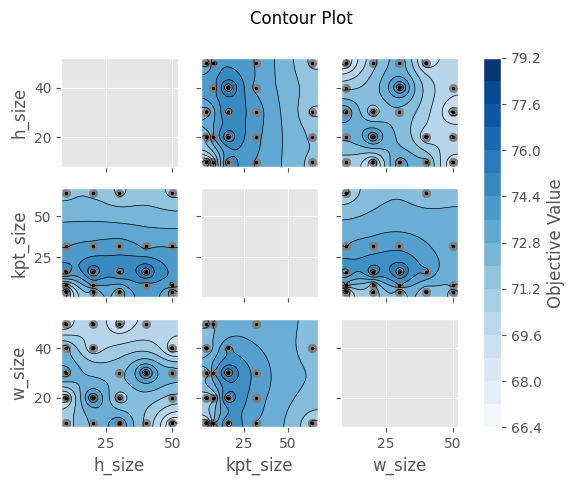

In [201]:
optuna.visualization.matplotlib.plot_contour(study)

#### Dense SIFT function:
First all keypoints are obtained using the hyperparameters. Then, the SIFT descriptor is applied on each keypoint and the descriptors are returned.

In [202]:
def dense_sift(img, keypoint_size=16, h_size=40, w_size=30):
    # Compute SIFT descriptors at each grid point
    h, w = img.shape
    step_size_h = int(h/h_size)
    step_size_w = int(w/w_size)
    keypoints = [cv2.KeyPoint(x, y, keypoint_size) for y in range(0, h, step_size_h) for x in range(0, w, step_size_w)]
    _, descriptors = Detector.compute(img, keypoints)

    return keypoints, descriptors

### Descriptors of the Training Dataset
We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together for both SIFT and dense SIFT.

In [204]:
Train_descriptors = []
Train_dense_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    # Training descriptors for standard SIFT
    if standard_descriptor:
        kpt,des=Detector.detectAndCompute(gray,None)
        Train_descriptors.append(des)

    # Training descriptors for dense SIFT
    if dense_descriptor:
        d_kpt,d_des = dense_sift(gray)
        Train_dense_descriptors.append(d_des)

    Train_label_per_descriptor.append(labels)
    
D=np.vstack(Train_descriptors) if standard_descriptor else 0
dense_D=np.vstack(Train_dense_descriptors) if dense_descriptor else 0

### K-Means clustering
We now compute a k-means clustering on the descriptor space

In [205]:
#k = 128
k = 192
if standard_descriptor:
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D) 
    
if dense_descriptor:
    d_codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    d_codebook.fit(dense_D)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


### Create Training Visual words for BOVW
And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [206]:
if standard_descriptor:
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)

if dense_descriptor:
    d_visual_words=np.zeros((len(Train_dense_descriptors),k),dtype=np.float32)
    for i in range(len(Train_dense_descriptors)):
        d_words=d_codebook.predict(Train_dense_descriptors[i])
        d_visual_words[i,:]=np.bincount(d_words,minlength=k)

### K-NN Classifier
We build a k-nn classifier and train it with the train descriptors

In [209]:
if standard_descriptor:
    knn = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels) 
if dense_descriptor:
    d_knn = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    d_knn.fit(d_visual_words, train_labels) 

### Descriptors from Test Dataset
We end up computing the test descriptors and compute the accuracy of both SIFT and dense SIFT models.

In [210]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_dense_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    # Test descriptors for standard SIFT
    if standard_descriptor:
        kpt,des=Detector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    # Test descriptors for dense SIFT
    if dense_descriptor:
        d_kpt,d_des = dense_sift(gray)
        dense_words=d_codebook.predict(d_des)
        visual_words_dense_test[i,:]=np.bincount(dense_words,minlength=k)

In [211]:
if standard_descriptor:
    accuracy = 100*knn.score(visual_words_test, test_labels)
    print(f"SIFT accuracy: {accuracy}")
if dense_descriptor:
    dense_accuracy = 100*d_knn.score(visual_words_dense_test, test_labels)
    print(f"Dense SIFT accuracy: {dense_accuracy}")
#old params
# SIFT accuracy: 60.223048327137555
# Dense SIFT accuracy: 79.05824039653035
    
#new params
# SIFT accuracy: 62.32961586121437
# Dense SIFT accuracy: 76.45600991325898

SIFT accuracy: 62.32961586121437
Dense SIFT accuracy: 76.45600991325898


For categorization the dense SIFT method is more suitable because it takes into account elements of the background that are not relevant for the SIFT method but are still useful to determine which category each image belongs to.

### Dimensionality reduction, with PCA and LDA

#### PCA

In [234]:
if standard_descriptor:
    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(d_visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_dense_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    print(f"Dense SIFT accuracy: {accuracy}")
#old params
# SIFT accuracy: 59.85130111524164
# Dense SIFT accuracy: 77.69516728624535
    
#new params
# SIFT accuracy: 62.825278810408925
# Dense SIFT accuracy: 77.32342007434944

SIFT accuracy: 62.949194547707556
Dense SIFT accuracy: 76.82775712515489


#### LDA

In [227]:
if standard_descriptor:
    lda = LinearDiscriminantAnalysis(n_components=7)
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    lda = LinearDiscriminantAnalysis(n_components=7)
    VWlda = lda.fit_transform(d_visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_dense_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    print(f"Dense SIFT accuracy: {accuracy}")

#old params
# SIFT accuracy: 64.68401486988847
# Dense SIFT accuracy: 81.41263940520446
    
#new params
# SIFT accuracy: 65.55142503097893
# Dense SIFT accuracy: 81.16480793060718

SIFT accuracy: 65.55142503097893
Dense SIFT accuracy: 81.16480793060718


Optuna to test different values for k in kmeans

/var/folders/qc/m4g25b2541l5c9lvd5h69wqm0000gn/T/ipykernel_68737/1894382642.py:8: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2023-12-30 13:02:54,953] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Best Hyperparameters: {'k_means_clusters': 192, 'knn_distance_metric': 'euclidean', 'knn_neighbors': 10}


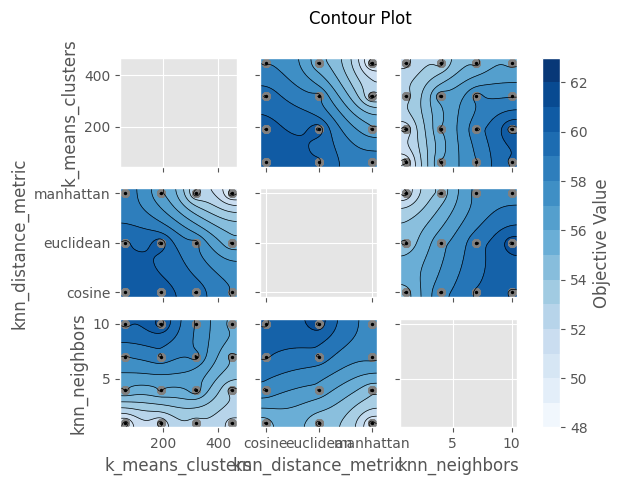

In [220]:
import optuna.visualization as vis
import nbformat

# Load the existing study from the database
loaded_study = optuna.load_study(
    study_name="a11111", storage="sqlite:///hparam.db"
)
optuna.visualization.matplotlib.plot_contour(loaded_study)

# Get the best hyperparameters
best_params = loaded_study.best_params
print("Best Hyperparameters:", best_params)

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [226]:


# Assuming you have your training data in 'visual_words' and corresponding labels in 'train_labels'
# and your test data in 'visual_words_test'

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=10000)  
# Convert string labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(train_labels))}
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])

# Train the model
logistic_reg.fit(visual_words, train_labels_numeric)

# Make predictions on the test data
predictions_numeric = logistic_reg.predict(visual_words_test)

# Assuming you have a label_mapping dictionary that maps numerical labels to string labels
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}

# Convert numerical predictions back to string labels
predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])

# Assuming you have test labels in 'test_labels'
# Calculate the accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy for logistic regression (SIFT): {100*accuracy}")


Accuracy for logistic regression: 59.97521685254027


In [238]:
# with dense SIFT
# d_kpt,d_des = dense_sift(gray)
#         dense_words=d_codebook.predict(d_des)
#         visual_words_dense_test[i,:]=np.bincount(dense_words,minlength=k)
# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=10000)  
# Convert string labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(train_labels))}
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])

# Train the model
logistic_reg.fit(d_visual_words, train_labels_numeric)

# Make predictions on the test data
predictions_numeric = logistic_reg.predict(visual_words_dense_test)

# Assuming you have a label_mapping dictionary that maps numerical labels to string labels
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}

# Convert numerical predictions back to string labels
predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])

# Assuming you have test labels in 'test_labels'
# Calculate the accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy for logistic regression (dense SIFT): {100*accuracy}")

Accuracy for logistic regression: 75.46468401486989


In [241]:
def apply_dimensionality_reduction_and_classification(X_train, X_test, train_labels, test_labels, reduction_method):
    if reduction_method == 'pca':
        reducer = PCA(n_components=64)
    elif reduction_method == 'lda':
        reducer = LinearDiscriminantAnalysis(n_components=7)
    else:
        raise ValueError("Invalid reduction method. Use 'pca' or 'lda'.")

    X_train_reduced = reducer.fit_transform(X_train, train_labels)
    X_test_reduced = reducer.transform(X_test)

    # Create a logistic regression model
    logistic_reg = LogisticRegression(max_iter=10000) 
    # Train the model
    logistic_reg.fit(X_train_reduced, train_labels)

    # Make predictions on the test data
    predictions = logistic_reg.predict(X_test_reduced)

    # Calculate the accuracy
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Accuracy ({reduction_method}): {accuracy * 100:.2f}%")


In [242]:
# Apply PCA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('PCA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca')

# Apply PCA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('PCA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(d_visual_words, visual_words_dense_test, train_labels, test_labels, 'pca')

# Apply LDA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('LDA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda')

# Apply LDA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('LDA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(d_visual_words, visual_words_dense_test, train_labels, test_labels, 'lda')

PCA and Logistic Regression for standard descriptors:
Accuracy (pca): 71.13%
PCA and Logistic Regression for dense descriptors:
Accuracy (pca): 79.06%
LDA and Logistic Regression for standard descriptors:
Accuracy (lda): 66.91%
LDA and Logistic Regression for dense descriptors:
Accuracy (lda): 83.15%
